# 딥러닝의 기본 이미지 분류하기
## Chapter 4 흉부 엑스레이 분석과 데이터 증강하기

In [ ]:
import os
from pathlib import Path
import random


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from torch import nn,optim
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from collections import OrderedDict
from tqdm import tqdm

is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

seed = 1010
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

### 4.1 데이터셋

In [1]:
%cd /content/drive/MyDrive/Colab\ Notebooks/프로젝트로\ 시작하는\ Pytorch/5.4

/content/drive/MyDrive/Colab Notebooks/프로젝트로 시작하는 Pytorch/5.4


In [2]:
!unzip -qq -n "Chest X-Ray Pneumonia.zip" -d dataset

In [3]:
%ls dataset/chest_xray/train

NORMAL/  PNEUMONIA/


In [4]:
import os

print("Train")
print("NORMAL:", len(os.listdir("dataset/chest_xray/train/NORMAL")), end=', ')
print("PNEUMONIA:", len(os.listdir("dataset/chest_xray/train/PNEUMONIA")))
print()
print("Validation")
print("NORMAL:", len(os.listdir("dataset/chest_xray/val/NORMAL")), end=', ')
print("PNEUMONIA:", len(os.listdir("dataset/chest_xray/val/PNEUMONIA")))
print()
print("Test")
print("NORMAL:", len(os.listdir("dataset/chest_xray/test/NORMAL")), end=', ')
print("PNEUMONIA:", len(os.listdir("dataset/chest_xray/test/PNEUMONIA")))

Train
NORMAL: 1341, PNEUMONIA: 3875

Validation
NORMAL: 8, PNEUMONIA: 8

Test
NORMAL: 234, PNEUMONIA: 390


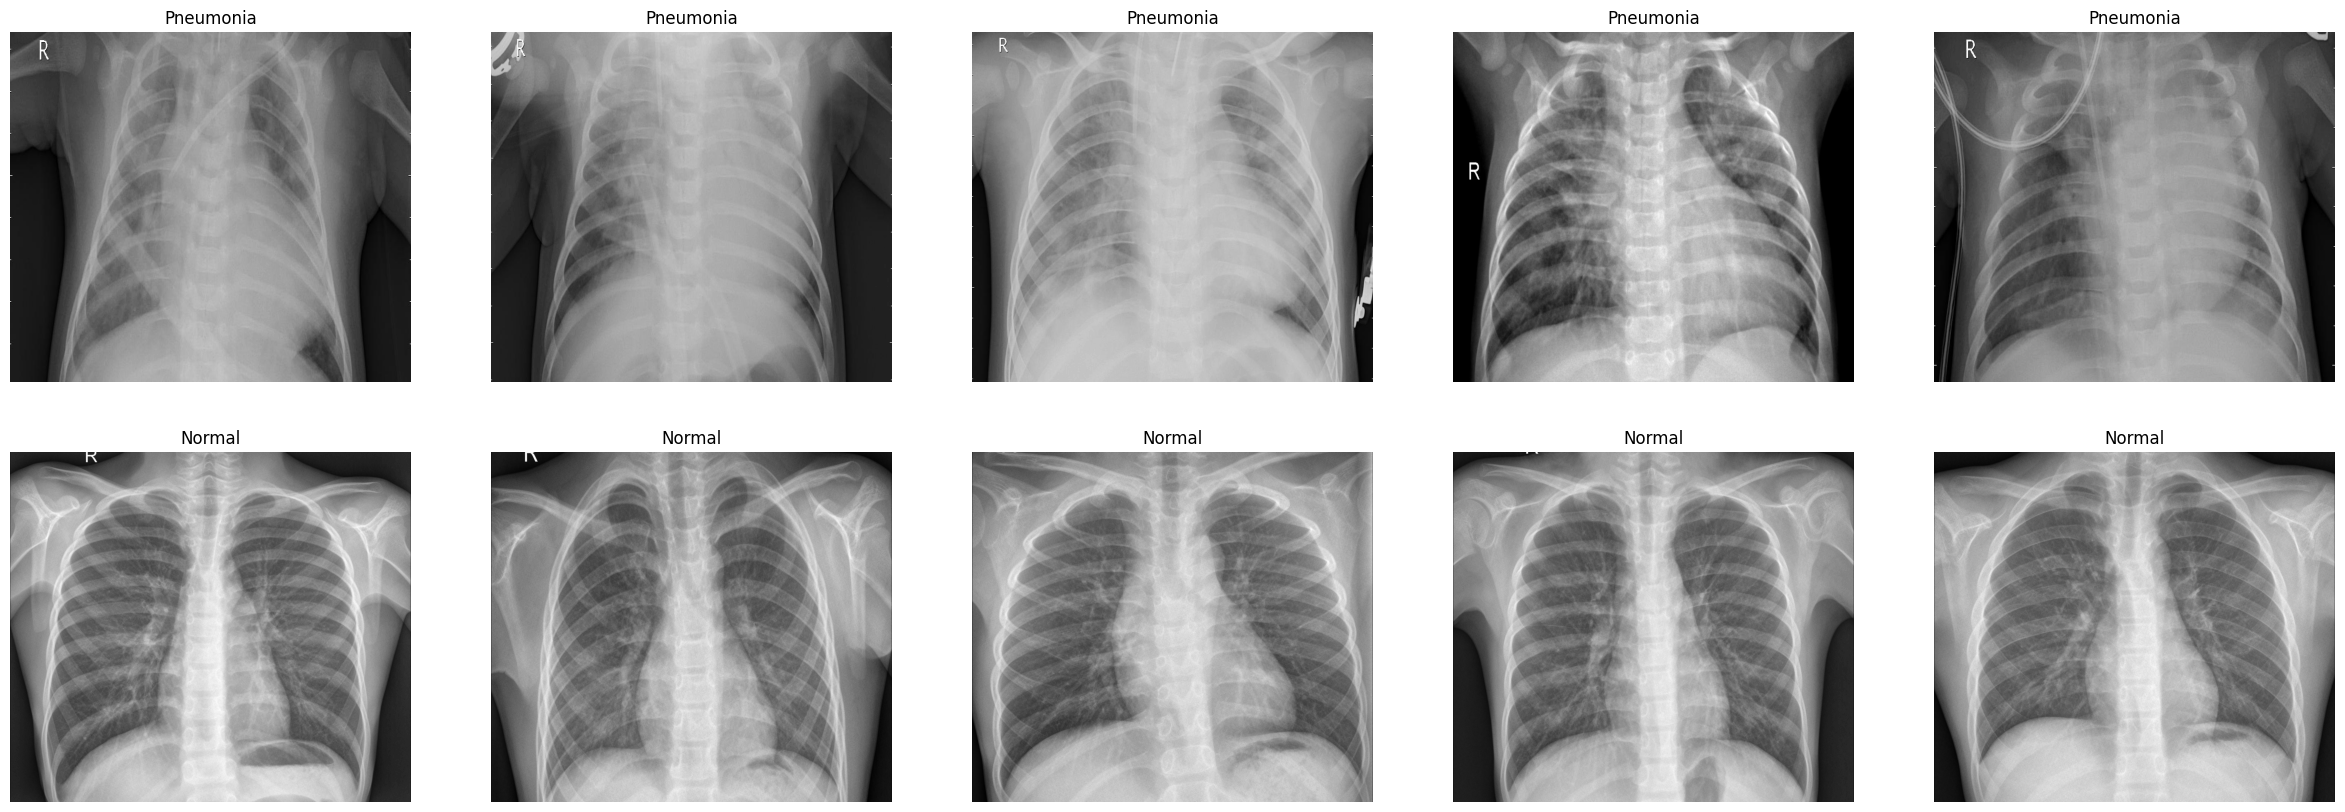

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

root = "dataset/chest_xray/test/"
normal_dir = root + 'NORMAL/'
pneumonia_dir = root + 'PNEUMONIA/'

normal = list(map(lambda x: normal_dir+x, os.listdir(normal_dir)[:5]))
pneumonia = list(map(lambda x: pneumonia_dir+x, os.listdir(pneumonia_dir)[:5]))

samples = pneumonia + normal

# show samples
plt.figure(figsize=(30,10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  img = Image.open(samples[i])

  ax = plt.gca()
  ax.set_title("Pneumonia" if i < 5 else "Normal")
  ax.imshow(img, cmap='gray')
  ax.axis('off')
  ax.set_aspect('auto')
plt.show()

#### 이미지 폴더(ImageFolder)

In [9]:
def get_dataset(
    root="dataset/chest_xray", val=0.1,
    train_transforms=None, test_transforms=None
):
  origin = datasets.ImageFolder(
      os.path.join(root, 'train'),
      transform=train_transforms
  )

  val_samples = int(len(origin) * val)
  train_samples = len(origin) - val_samples

  trainset, valset = torch.utils.data.random_split(
    origin,
    (train_samples, val_samples),
  )
  valset.transforms = test_transforms

  testset = datasets.ImageFolder(
      os.path.join(root, 'test'),
      transform=test_transforms
  )
  return trainset, valset, testset

trainset, valset, testset = get_dataset(train_transforms=transforms.ToTensor())
print(len(trainset), len(valset), len(testset))

4695 521 624


In [10]:
class_names = trainset.dataset.classes
print(class_names)
print(trainset.dataset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [11]:
image, label = trainset[0]

print(image.shape)
print(label)

torch.Size([3, 928, 1310])
1


### 4.2 데이터 증강과 Albumentation

In [12]:
!pip install -q -U opencv-python
!pip install -q -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 11.3 MB/s eta 0:00:00


In [13]:
import cv2
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [14]:
train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomRotation(degrees=(-20,+20)),
        transforms.RandomCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

trainset, _, _ = get_dataset(
  train_transforms=train_transform,
)

train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=64,
  num_workers=0,
)

for i in tqdm(train_loader):
  pass


100%|██████████| 74/74 [15:44<00:00, 12.76s/it]


In [15]:
class AlbumentationsDataset(ImageFolder):

  def __getitem__(self, index: int):
    path, target = self.samples[index]
    # Read image
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transform
    if self.transform is not None:
      augmented = self.transform(image=image)
      image = augmented['image']

    return image, target

In [16]:
def get_dataset_v2(root="dataset/chest_xray", val=0.1, train_transforms=None, test_transforms=None):
  origin = AlbumentationsDataset(os.path.join(root, 'train'), transform=train_transforms)

  val_samples = int(len(origin) * val)
  train_samples = len(origin) - val_samples

  trainset, valset = torch.utils.data.random_split(
    origin,
    (train_samples, val_samples),
  )
  valset.transforms = test_transforms

  testset = AlbumentationsDataset(os.path.join(root, 'test'), transform=test_transforms)
  return trainset, valset, testset

trainset, valset, testset = get_dataset_v2(train_transforms=None)
print(len(trainset), len(valset), len(testset))

4695 521 624


In [17]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
        A.Resize(256, 256),
        A.Rotate(limit=(-20, +20)),
        A.RandomCrop(224, 224),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2(),
])

trainset, _, _ = get_dataset_v2(
  train_transforms=train_transform,
)

train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=64,
  num_workers=0,
)

for i in tqdm(train_loader):
    pass

100%|██████████| 74/74 [01:51<00:00,  1.50s/it]


#### Albumentation만의 특별한 기능

In [18]:
test_transform = A.Compose([
        A.Resize(256,256),
        A.OneOf([
            A.HorizontalFlip(p=1),
            A.RandomRotate90(p=1),
            A.VerticalFlip(p=1)
        ], p=1),
        A.CenterCrop(224, 224),
        A.OneOf([
            A.MotionBlur(p=0.3),
            A.OpticalDistortion(p=0.4),
            A.GaussNoise(p=0.5)
        ], p=0.5),
        ToTensorV2(),
])

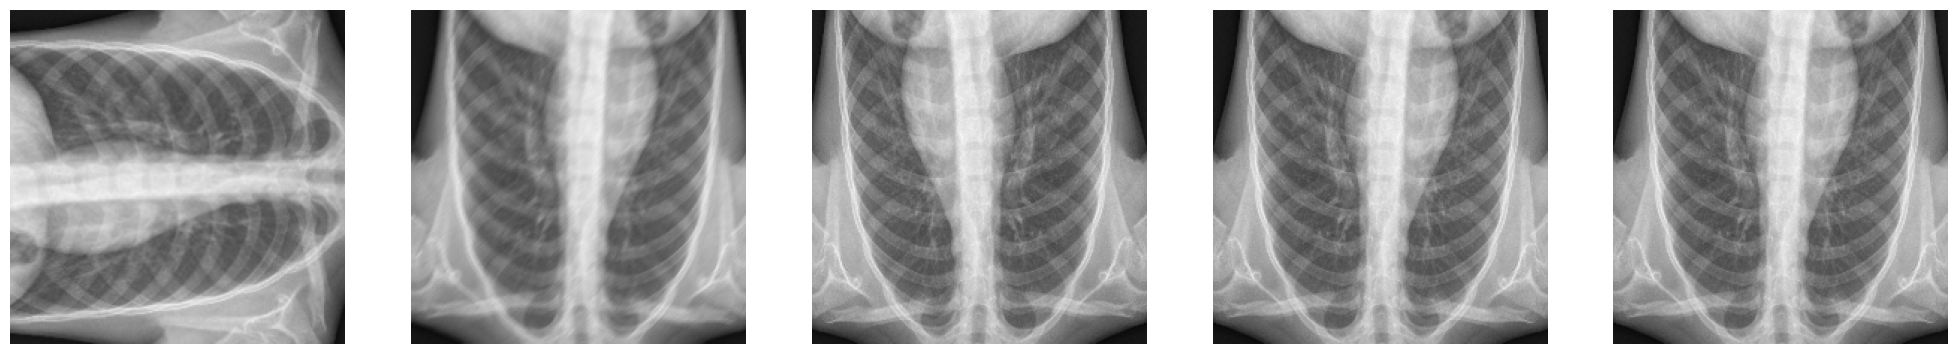

In [19]:
data_dir = Path("dataset/chest_xray/")
testset = AlbumentationsDataset(data_dir / 'test', transform=test_transform)

num_samples = 5
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(testset[0][0]))
  ax[i].axis('off')

### 4.3 학습 모델(ResNet18)

In [20]:
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
def load_resnet():
  model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
  model.fc = nn.Linear(in_features=512, out_features=1, bias=True)  ###

  return model

### 4.4 학습 및 기록(Wandb)

In [22]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [23]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [28]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  # train mode
  model.train()

  # 학습 통계
  running_loss = 0
  correct = 0

  with tqdm(dataloader) as pbar:
    for i, (data, targets) in enumerate(pbar):
      data, targets = data.to(device), targets.to(device)

      optimizer.zero_grad()
      outputs = model(data)
      loss = criterion(outputs, targets.unsqueeze(1).float()) #### Change
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

      # Accuracy 계산
      with torch.no_grad():
        predicted = torch.sigmoid(outputs).round() #### Change
        correct += predicted.eq(targets.view_as(predicted)).sum()

    # Accuracy 출력
    data_num = len(dataloader.dataset)
    acc = 100. * correct / data_num
    print(
        f"[{epoch}/{EPOCH}]",
        f"train loss: {running_loss/len(dataloader):.4f}",
        f"train acc: {correct}/{data_num} ({acc:.2f}%)"
    )

  return running_loss/len(dataloader), acc

In [29]:
def validation(model, dataloader, criterion, epoch, device):
  # eval 모드
  model.eval()

  # 검증 통계
  correct = 0
  running_loss = 0.

  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (data, targets) in enumerate(pbar):
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets.unsqueeze(1).float())  #### Change

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

        # Accuracy 계산
        predicted = torch.sigmoid(outputs).round() #### Change
        correct += predicted.eq(targets.view_as(predicted)).sum()

  # Accuracy 계산
  data_num = len(dataloader.dataset)
  acc = 100. * correct / data_num
  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f} valid acc: {correct}/{data_num} ({acc:.2f}%)\n')

  return running_loss/len(dataloader), acc

In [30]:
def test(model, dataloader, device):
    # eval 모드
    model.eval()

    # 테스트 통계
    correct = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
      for data, targets in dataloader:
        data, targets = data.to(device), targets.to(device)

        outputs = model(data)    # forward

        # Accuracy 계산
        predicted = torch.sigmoid(outputs).round()  ### Change
        correct += predicted.eq(targets.view_as(predicted)).sum()

        y_true.append(targets)
        y_pred.append(outputs)

    # Accuracy 계산
    data_num = len(dataloader.dataset)
    print(f'Test Accuracy: {correct}/{data_num} ({100. * correct / data_num:.2f}%)')

    return 100. * correct / data_num, torch.cat(y_true), torch.cat(y_pred)

In [27]:
import wandb

wandb.init(project="Pneumonia", save_code=True)

EPOCH = 10
BATCH_SIZE = 256
NUM_WORKERS = 0
LR = 0.001

wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCH,
  "batch_size": BATCH_SIZE,
  "num_workers": NUM_WORKERS
}

train_transform = A.Compose([
        A.Resize(256, 256),
        A.Rotate(limit=(-20, +20)),
        A.RandomCrop(224, 224),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2(),
])
test_transform = A.Compose([
        A.Resize(256, 256),
        A.CenterCrop(224, 224),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2(),
])

trainset, valset, testset = get_dataset_v2(
  train_transforms=train_transform,
  test_transforms=test_transform
)

# dataloader
train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
test_loader = DataLoader(
  dataset=testset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)

# Model
model = load_resnet()

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model = model.to(device)
criterion = criterion.to(device)

max_acc = 0
# Start Training
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss, tacc = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss, vacc = validation(model, val_loader, criterion, epoch, device)

  wandb.log({
      "lr": scheduler.get_last_lr()[0],
      "train_loss": tloss,
      "train_accuracy": tacc,
      "val_loss": vloss,
      "val_acc": vacc
  })
  scheduler.step()

  if vacc > max_acc:
    torch.save(model.state_dict(), "best.pth")

# load best model
model.load_state_dict(torch.load("best.pth"))
artifact = wandb.Artifact('best', type='checkpoint')
artifact.add_file('best.pth')
wandb.log_artifact(artifact)

# Test
tacc, y_true, y_preds = test(model, test_loader, device)
class_names = testset.classes
wandb.log({
  "test_accuracy": tacc,
  "conf_mat": wandb.plot.confusion_matrix(probs=None,
                y_true=y_true.tolist(),
                preds=torch.sigmoid(y_preds).squeeze().round().int().tolist(),
                class_names=class_names)})
wandb.finish()

wandb: Currently logged in as: kairos03. Use `wandb login --relogin` to force relogin


LR: [0.001]


100%|██████████| 19/19 [02:01<00:00,  6.39s/it, loss=0.0877]


[0/10] train loss: 0.1671 train acc: 4386/4695 (93.42%)


100%|██████████| 3/3 [00:09<00:00,  3.26s/it, loss=0.659]


[0/10] valid loss: 0.4239 valid acc: 462/521 (88.68%)

LR: [0.001]


100%|██████████| 19/19 [01:45<00:00,  5.57s/it, loss=0.037]


[1/10] train loss: 0.0561 train acc: 4601/4695 (98.00%)


100%|██████████| 3/3 [00:09<00:00,  3.03s/it, loss=0.0359]


[1/10] valid loss: 0.2016 valid acc: 476/521 (91.36%)

LR: [0.001]


100%|██████████| 19/19 [01:45<00:00,  5.54s/it, loss=0.0163]


[2/10] train loss: 0.0392 train acc: 4623/4695 (98.47%)


100%|██████████| 3/3 [00:09<00:00,  3.14s/it, loss=0.337]


[2/10] valid loss: 0.1424 valid acc: 512/521 (98.27%)

LR: [0.0005]


100%|██████████| 19/19 [01:45<00:00,  5.55s/it, loss=0.0317]


[3/10] train loss: 0.0316 train acc: 4638/4695 (98.79%)


100%|██████████| 3/3 [00:10<00:00,  3.40s/it, loss=0.00962]


[3/10] valid loss: 0.0327 valid acc: 513/521 (98.46%)

LR: [0.0005]


100%|██████████| 19/19 [01:43<00:00,  5.45s/it, loss=0.0323]


[4/10] train loss: 0.0208 train acc: 4669/4695 (99.45%)


100%|██████████| 3/3 [00:11<00:00,  3.72s/it, loss=0.00302]


[4/10] valid loss: 0.0272 valid acc: 513/521 (98.46%)

LR: [0.0005]


100%|██████████| 19/19 [01:44<00:00,  5.49s/it, loss=0.0172]


[5/10] train loss: 0.0175 train acc: 4671/4695 (99.49%)


100%|██████████| 3/3 [00:11<00:00,  3.91s/it, loss=0.00497]


[5/10] valid loss: 0.0650 valid acc: 506/521 (97.12%)

LR: [0.00025]


100%|██████████| 19/19 [01:44<00:00,  5.48s/it, loss=0.00466]


[6/10] train loss: 0.0144 train acc: 4666/4695 (99.38%)


100%|██████████| 3/3 [00:10<00:00,  3.62s/it, loss=0.0557]


[6/10] valid loss: 0.0578 valid acc: 508/521 (97.50%)

LR: [0.00025]


100%|██████████| 19/19 [01:42<00:00,  5.38s/it, loss=0.0453]


[7/10] train loss: 0.0126 train acc: 4677/4695 (99.62%)


100%|██████████| 3/3 [00:10<00:00,  3.44s/it, loss=0.0066]


[7/10] valid loss: 0.0255 valid acc: 512/521 (98.27%)

LR: [0.00025]


100%|██████████| 19/19 [01:44<00:00,  5.51s/it, loss=0.0158]


[8/10] train loss: 0.0128 train acc: 4675/4695 (99.57%)


100%|██████████| 3/3 [00:10<00:00,  3.37s/it, loss=1.05]


[8/10] valid loss: 0.4512 valid acc: 487/521 (93.47%)

LR: [0.000125]


100%|██████████| 19/19 [01:45<00:00,  5.57s/it, loss=0.00369]


[9/10] train loss: 0.0055 train acc: 4690/4695 (99.89%)


100%|██████████| 3/3 [00:08<00:00,  2.95s/it, loss=0.00718]


[9/10] valid loss: 0.0349 valid acc: 513/521 (98.46%)

Test Accuracy: 552/624 (88.46%)


lr,███▄▄▄▂▂▂▁
test_accuracy,▁
train_accuracy,▁▆▆▇██▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▃███▇▇█▄█
val_loss,█▄▃▁▁▂▂▁█▁
lr,0.00013
test_accuracy,88.46154
train_accuracy,99.8935
train_loss,0.00548
val_acc,98.46449
